In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

# reading data
def read_hdf5(filename):
    N = int(10000)
    data = {}
    with h5py.File(filename, 'r') as hdf_file:
        names = list(hdf_file.keys())
        print('File opened')
        for name in names:
            data[name] = hdf_file[name][:N]
    return data

data = read_hdf5('Datasets/sample_2e7_design_precessing_higherordermodes_3detectors.h5')


File opened


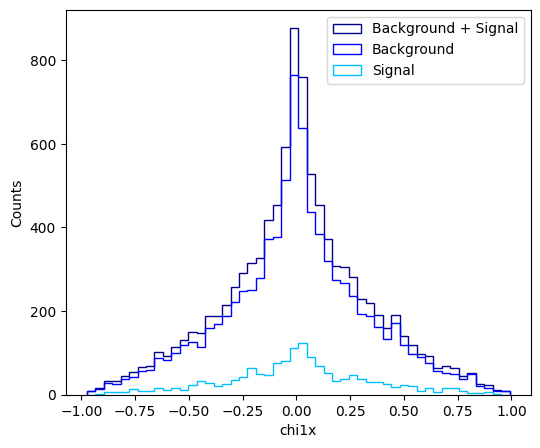

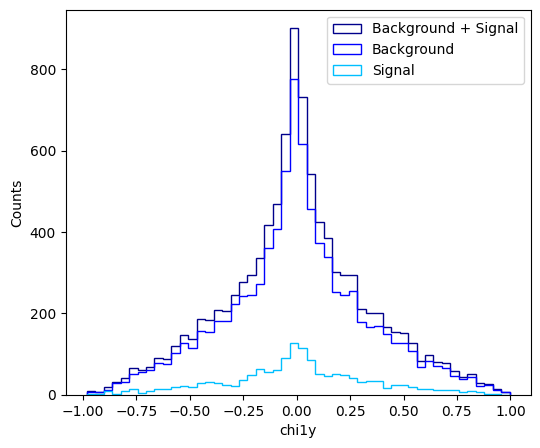

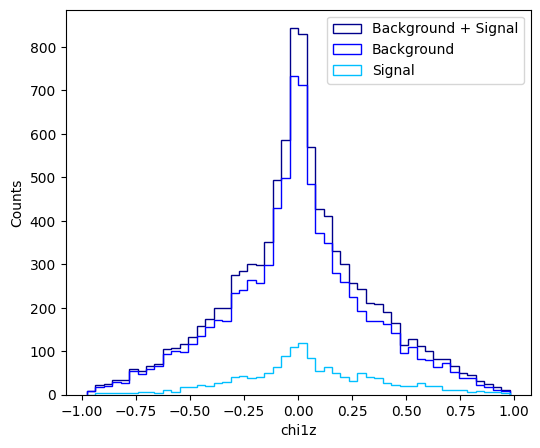

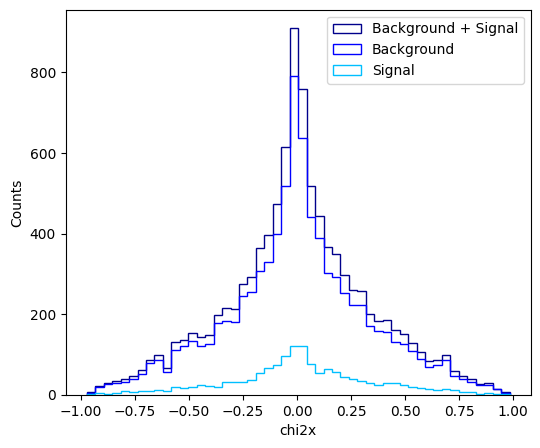

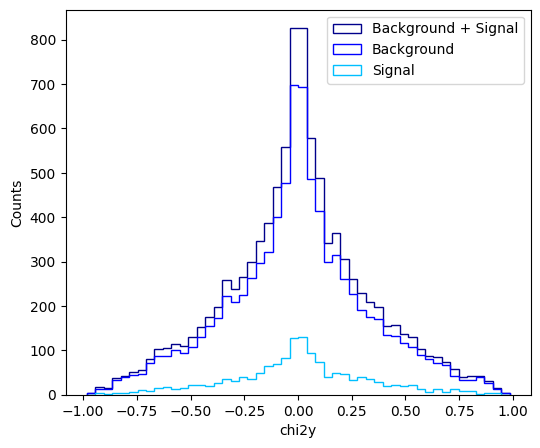

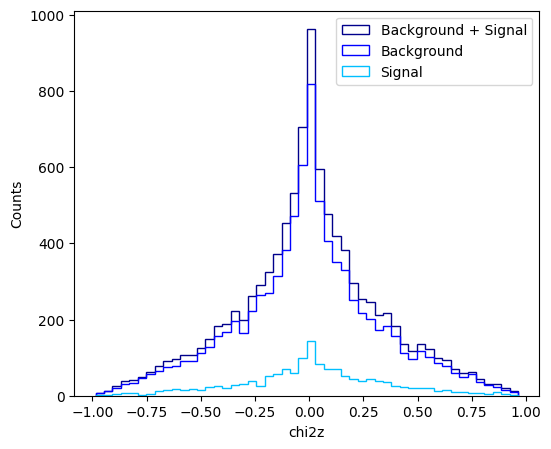

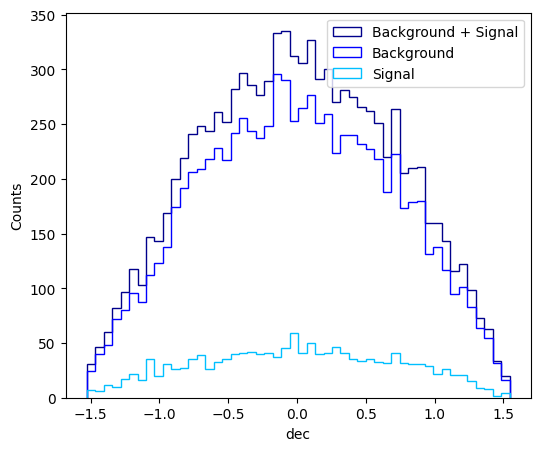

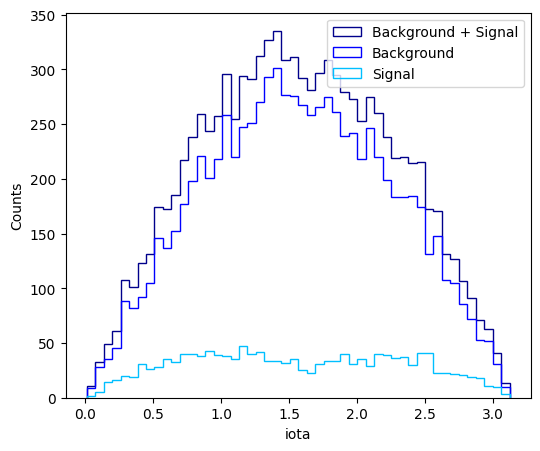

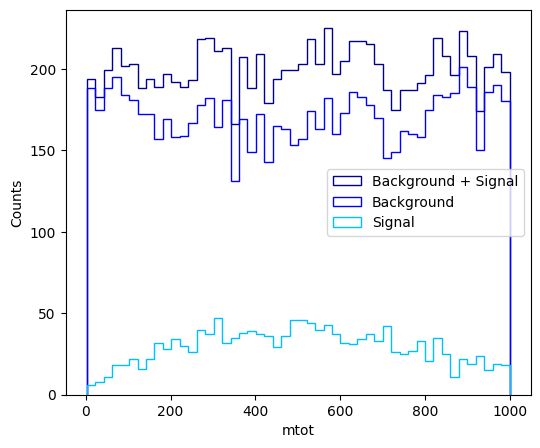

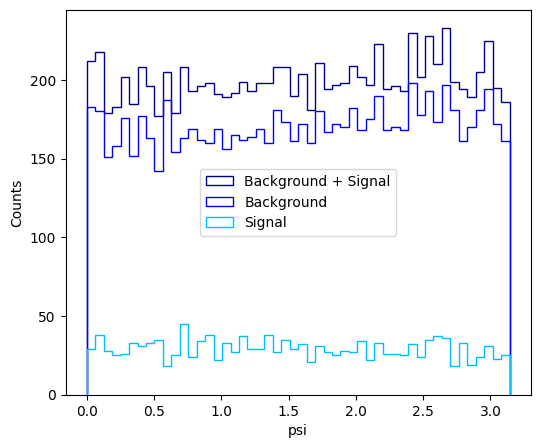

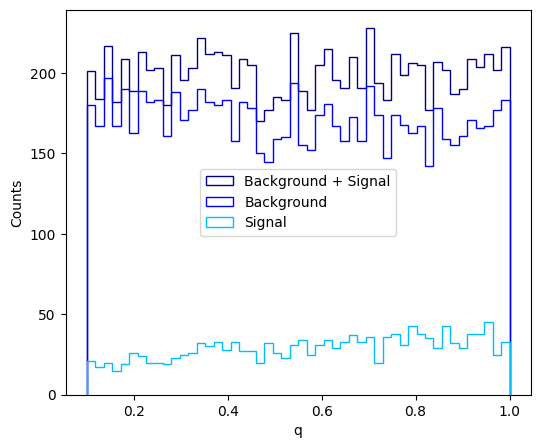

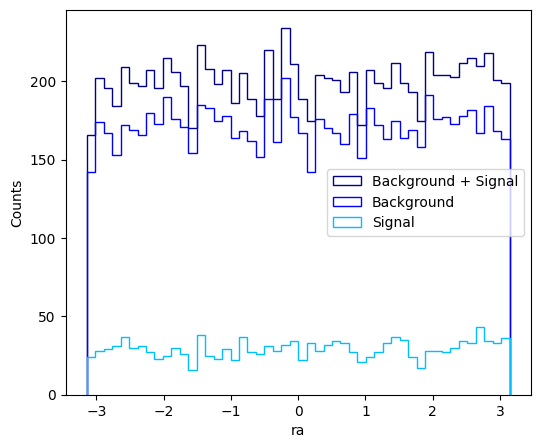

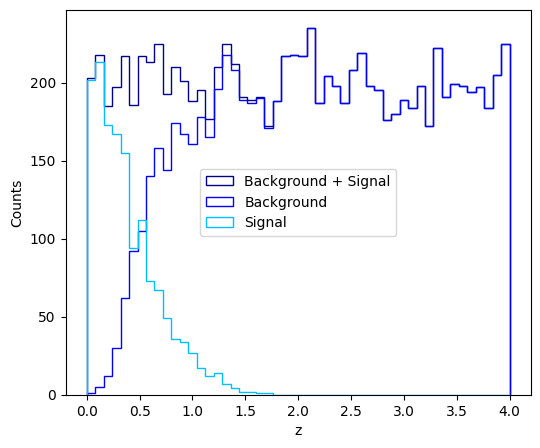

In [3]:
# let's first plot the distributions
labels=['Background','Signal']
colors=['blue','deepskyblue']
for name in data.keys():
    if name != 'det' and name != 'snr':
        fig,ax = plt.subplots(1,1,figsize=(6,5))
        limits = (min(data[name]), max(data[name]))
        ax.hist(data[name][:],label='Background + Signal',range=limits,bins=50,histtype='step',color='darkblue')
        for index in [0,1]:
            ax.hist(data[name][data['det']==index],label=labels[index],range=limits,bins=50,histtype='step',color=colors[index])
        ax.set(xlabel=name,ylabel='Counts')
        ax.legend()

In [4]:
from sklearn.model_selection import train_test_split

X=[]
for target in ['mtot','q','chi1x','chi1y','chi1z','chi2x','chi2y','chi2z','ra','dec','iota','psi','z']:
    X.append(data[target][:])
X = np.array(X).T
y = np.array(data['det'][:])
print(len(y[y==1])/len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# print(X_train,X_test)

0.1462


In [5]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.base import clone

# let's first define a function that allows to create a pipeline
# with a model given as input and a standardscaler to normalize the data
def print_roc(model):
    pipe = make_pipeline(StandardScaler(),
                             clone(model))
    pipe.fit(X_train, y_train)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    y_pred = pipe.predict(X_test)
    
    C = confusion_matrix(y_test, y_pred)

    return fpr, tpr, C

/tmp/ipykernel_3968/353833854.py:81: RuntimeWarning: invalid value encountered in scalar divide
  contamination.append(fp/(tp+fp))


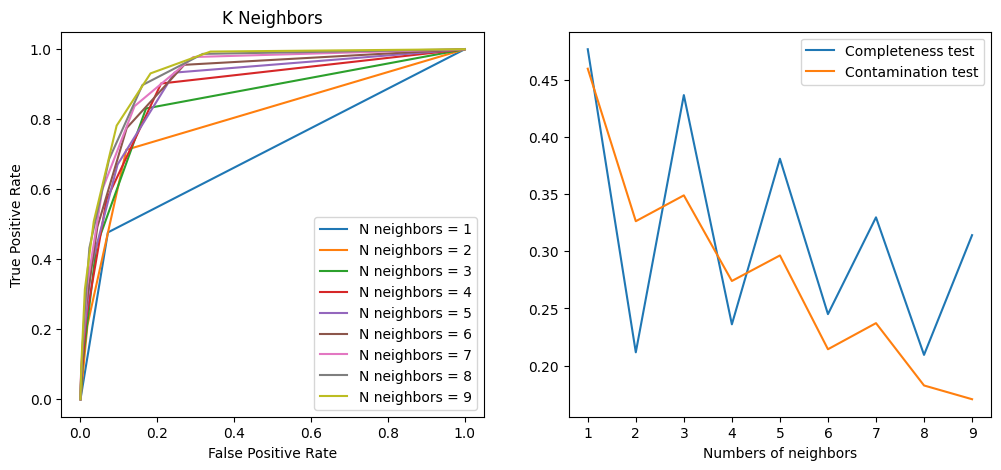

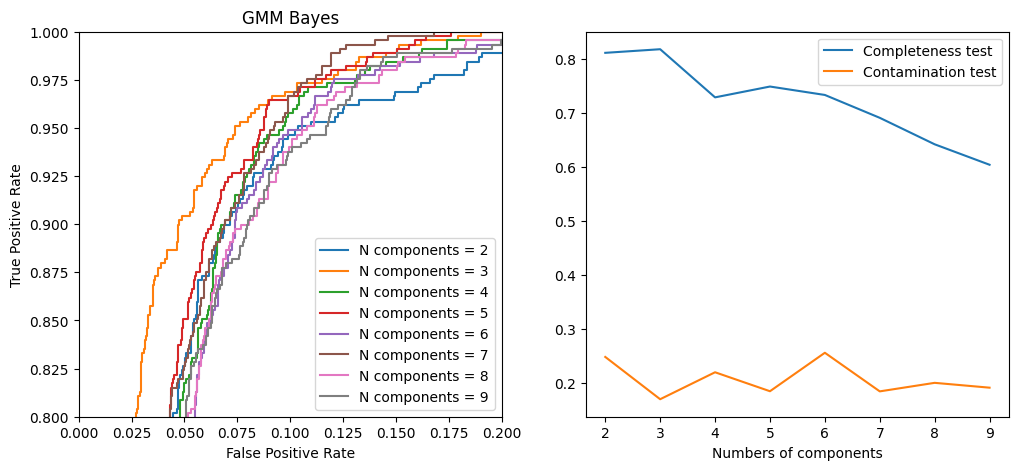

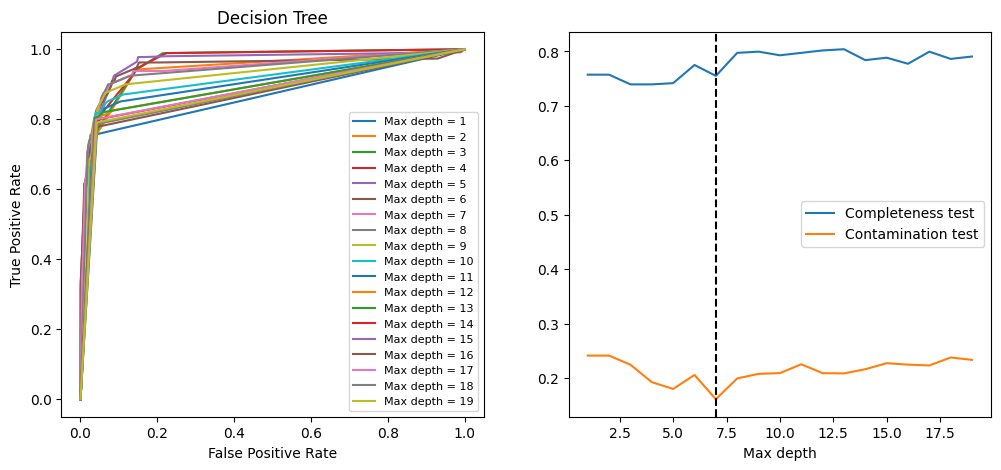

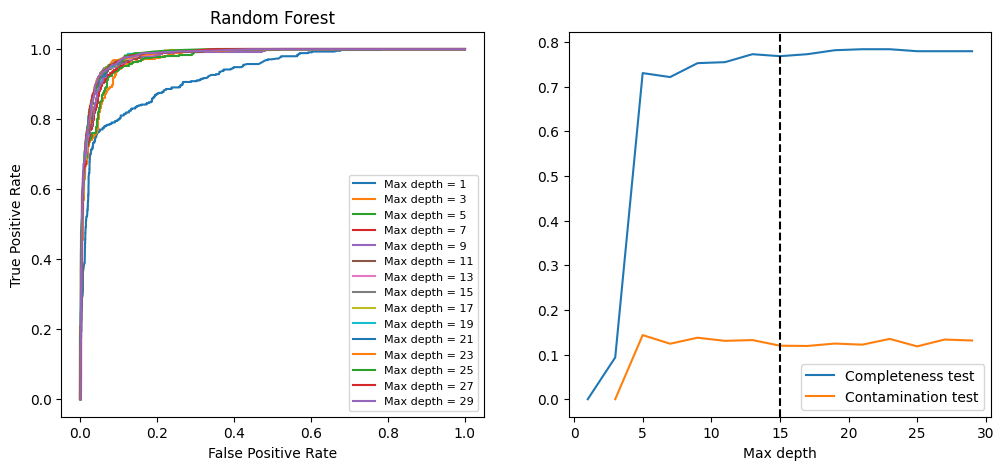

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from astroML.classification import GMMBayes
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# let's compute some models with different values for the respective parameter to briefly evaluate
# the best choice for that parameter (by looking at the roc curves)

# K Neighbors
fig,ax = plt.subplots(1,2,figsize=(12,5))
completeness=[]
contamination=[]
for i in np.arange(1,10):
    model = KNeighborsClassifier(n_neighbors=i)
    fpr, tpr, C = print_roc(model)
    tn, fp, fn, tp = C.ravel()
    completeness.append(tp/(tp+fn))
    contamination.append(fp/(tp+fp))
    ax[0].plot(fpr, tpr, label=f'N neighbors = {i:d}')
ax[0].set(xlabel='False Positive Rate',ylabel='True Positive Rate',title='K Neighbors')
ax[0].legend()
ax[1].plot(np.arange(1,10),completeness,label='Completeness test')
ax[1].plot(np.arange(1,10),contamination,label='Contamination test')
ax[1].set(xlabel='Numbers of neighbors')
ax[1].legend()

# GMM Bayes
fig,ax = plt.subplots(1,2,figsize=(12,5))
completeness=[]
contamination=[]
for i in np.arange(2,10):
    model = GMMBayes(n_components=i)
    fpr, tpr, C = print_roc(model)
    tn, fp, fn, tp = C.ravel()
    completeness.append(tp/(tp+fn))
    contamination.append(fp/(tp+fp))
    ax[0].plot(fpr, tpr, label=f'N components = {i:d}')
ax[0].set(xlabel='False Positive Rate',ylabel='True Positive Rate',title='GMM Bayes',
          xlim=(0,0.2),ylim=(0.8,1))
ax[0].legend()
ax[1].plot(np.arange(2,10),completeness,label='Completeness test')
ax[1].plot(np.arange(2,10),contamination,label='Contamination test')
ax[1].set(xlabel='Numbers of components')
ax[1].legend()

# note that for decisiontree and for randomforest the standard scaler function
# implemented in the pipeline before should not be necessary.
# since it doesn't affect the algorythms, in this case standardscaler has been used
# because later we'll confront different algorythms, for some of which is fundamental to rescale the data.
# in addition, this has be done also to keep the code as clean as possible by defining only one function

# Decision Tree
fig,ax = plt.subplots(1,2,figsize=(12,5))
completeness=[]
contamination=[]
for i in np.arange(1,20):
    model = DecisionTreeClassifier(max_depth=i)
    fpr, tpr, C = print_roc(model)
    tn, fp, fn, tp = C.ravel()
    completeness.append(tp/(tp+fn))
    contamination.append(fp/(tp+fp))
    ax[0].plot(fpr, tpr, label=f'Max depth = {i:d}')
ax[0].set(xlabel='False Positive Rate',ylabel='True Positive Rate',title='Decision Tree')
ax[0].legend(fontsize=8,loc='lower right')
ax[1].plot(np.arange(1,20),completeness,label='Completeness test')
ax[1].plot(np.arange(1,20),contamination,label='Contamination test')
ax[1].axvline(7,color='k',linestyle='--')
ax[1].set(xlabel='Max depth')
ax[1].legend()

# Random Forest
fig,ax = plt.subplots(1,2,figsize=(12,5))
completeness=[]
contamination=[]
for i in np.arange(1,30,2):
    model = RandomForestClassifier(max_depth=i)
    fpr, tpr, C = print_roc(model)
    tn, fp, fn, tp = C.ravel()
    completeness.append(tp/(tp+fn))
    contamination.append(fp/(tp+fp))
    ax[0].plot(fpr, tpr, label=f'Max depth = {i:d}')
ax[0].set(xlabel='False Positive Rate',ylabel='True Positive Rate',title='Random Forest')
ax[0].legend(fontsize=8,loc='lower right')
ax[1].plot(np.arange(1,30,2),completeness,label='Completeness test')
ax[1].plot(np.arange(1,30,2),contamination,label='Contamination test')
ax[1].axvline(15,color='k',linestyle='--')
ax[1].set(xlabel='Max depth')
ax[1].legend()

LogisticRegression(max_iter=10000)
Completeness: 0.777      Contamination: 0.224
GaussianNB()
Completeness: 0.857      Contamination: 0.296
LinearDiscriminantAnalysis()
Completeness: 0.693      Contamination: 0.203
QuadraticDiscriminantAnalysis()
Completeness: 0.873      Contamination: 0.270
GMMBayes(n_components=array([4]))
Completeness: 0.771      Contamination: 0.178
DecisionTreeClassifier(criterion='entropy', max_depth=7)
Completeness: 0.780      Contamination: 0.161
RandomForestClassifier(max_depth=15)
Completeness: 0.777      Contamination: 0.119


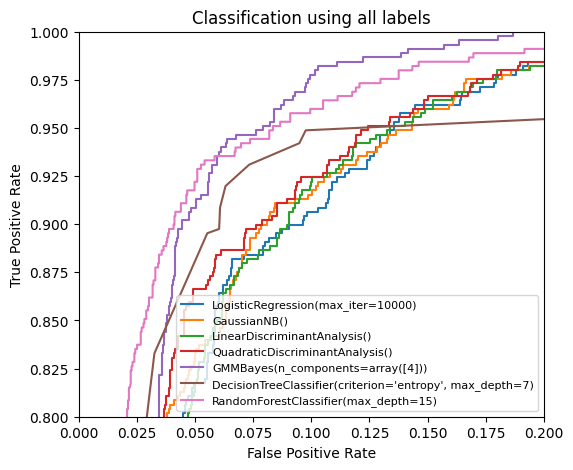

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA

# let's now compare different classification algorythms to find one that seems to behave well

fig,ax=plt.subplots(1,1,figsize=(6,5))

models=[
        LogisticRegression(max_iter=10000),
        GaussianNB(),
        LDA(),
        QDA(),
        GMMBayes(n_components=4),
        DecisionTreeClassifier(max_depth=7,criterion='entropy'),
        RandomForestClassifier(max_depth=15)
        ]
        

for j in models:
    fpr, tpr, C = print_roc(j)
    ax.plot(fpr, tpr, label=str(j))
    print(str(j))
    tn, fp, fn, tp = C.ravel()
    print(f'Completeness: {tp/(tp+fn):.3f}      Contamination: {fp/(tp+fp):.3f}')

ax.set(xlabel='False Positive Rate',ylabel='True Positive Rate',title='Classification using all labels',
xlim=(0,0.2),ylim=(0.8,1))
ax.legend(fontsize=8)

Best parameters: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 25}
Best score: 0.9571428571428571
Accuracy on test set: 0.9556666666666667
Confusion Matrix:
 [[2505   46]
 [  87  362]]
Completeness: 0.806      Contamination: 0.113


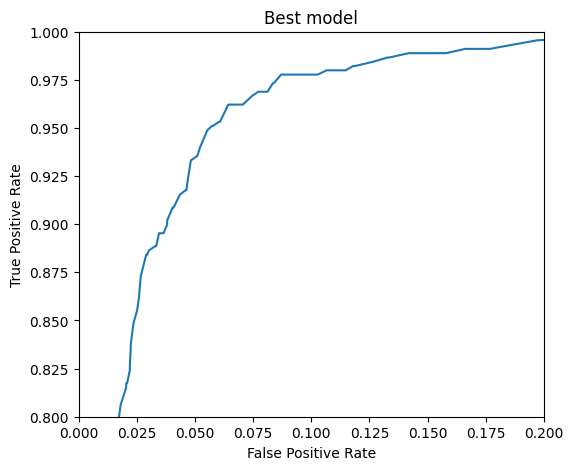

In [8]:
from sklearn.model_selection import GridSearchCV

# in terms of the roc curve and completeness&contamination values, randomforest seems the best,
# so let's crossvalidate (warning, with the parameters defined here it takes quite long to actually compute the code)
# note that in this case standardscaler has not been implemented because, as said, it shouldn't affect the result

model = RandomForestClassifier(random_state=42)
parameters = {'max_depth':np.arange(1,30),'criterion':['gini','entropy','log_loss'],'class_weight':['balanced','balanced_subsample']}

grid = GridSearchCV(model,param_grid=parameters,
                    cv=5, scoring='accuracy',n_jobs=-1)
grid.fit(X_train,y_train)

print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)
print("Accuracy on test set:", grid.score(X_test, y_test))

y_prob = grid.predict_proba(X_test)[:,1]
y_pred = grid.predict(X_test)

C = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n',C)
fpr, tpr, thresh = roc_curve(y_test, y_prob)
fig,ax = plt.subplots(1,1,figsize=(6,5))
ax.plot(fpr, tpr, label=f'Cross validated')
ax.set(xlabel='False Positive Rate',ylabel='True Positive Rate',title='Best model',
       xlim=(0,0.2),ylim=(0.8,1))
tn, fp, fn, tp = C.ravel()
print(f'Completeness: {tp/(tp+fn):.3f}      Contamination: {fp/(tp+fp):.3f}')

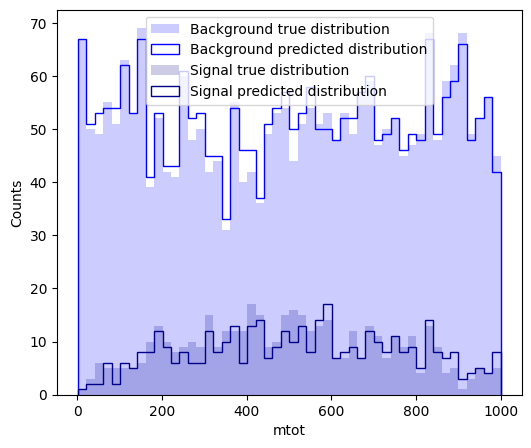

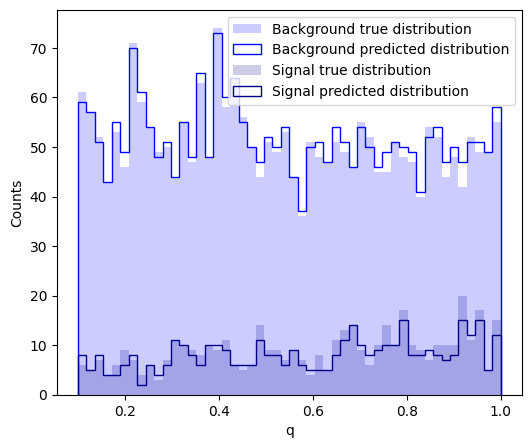

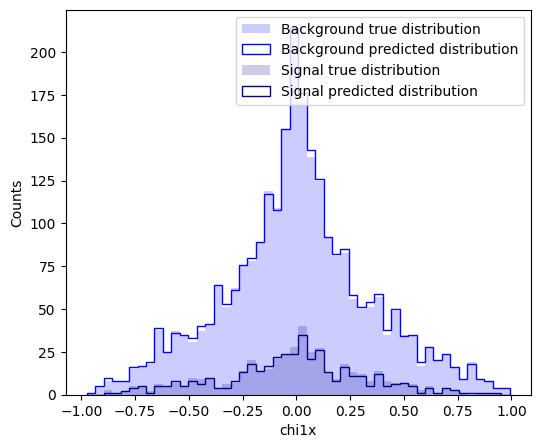

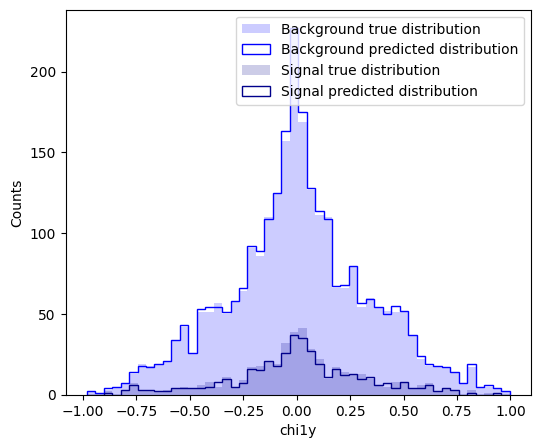

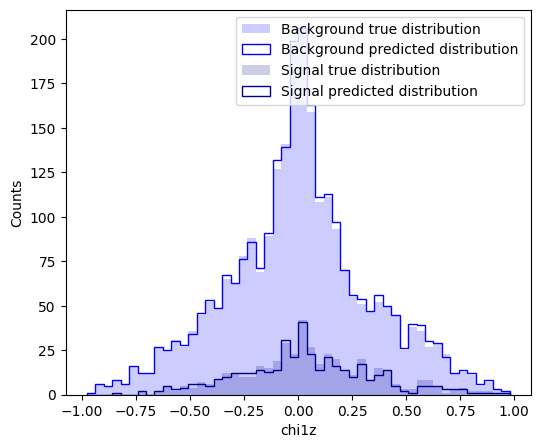

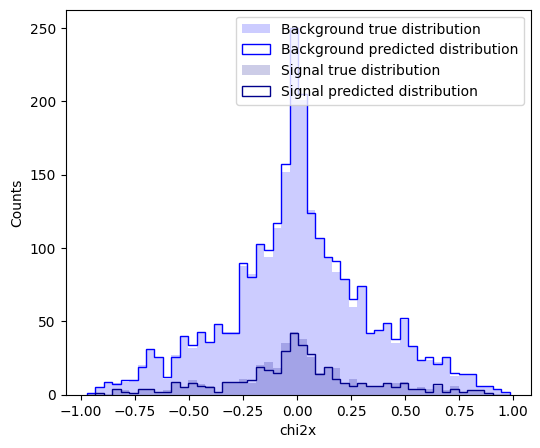

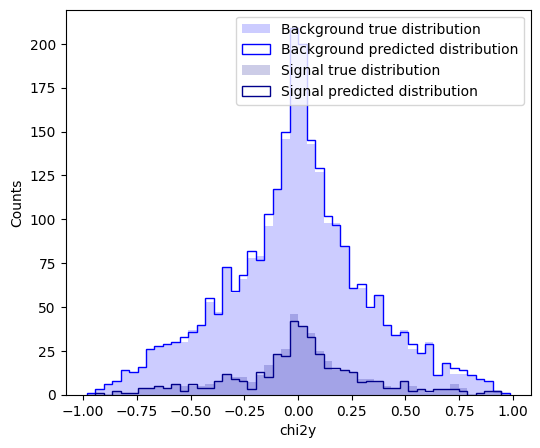

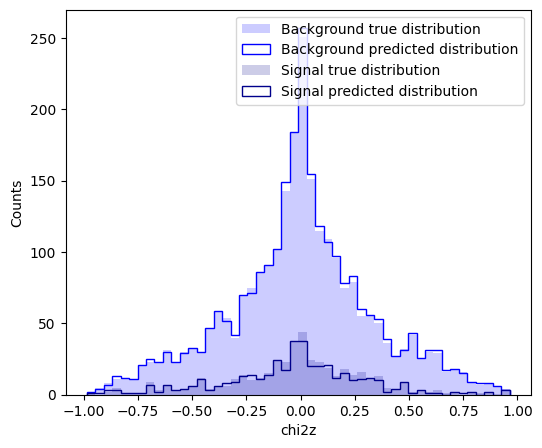

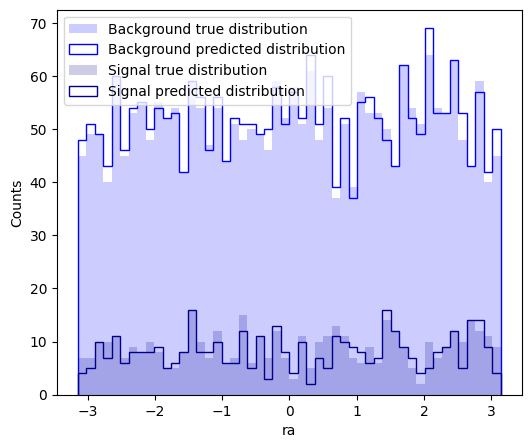

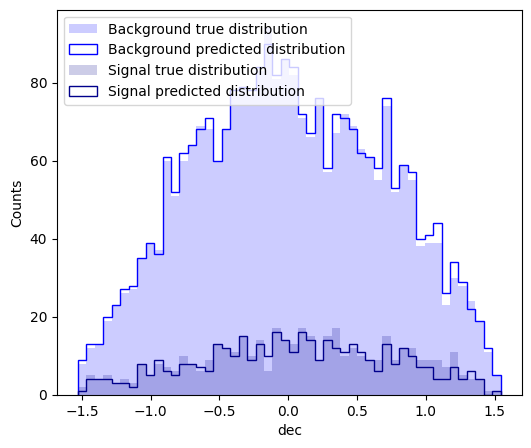

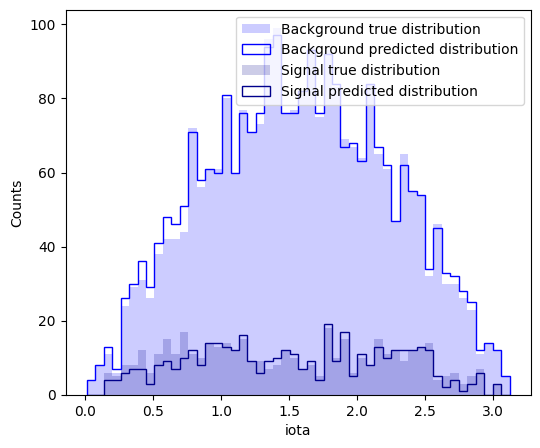

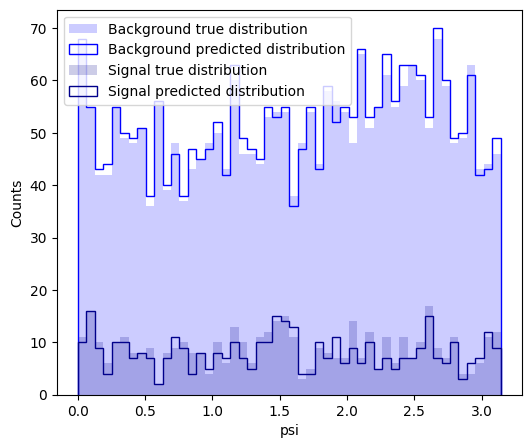

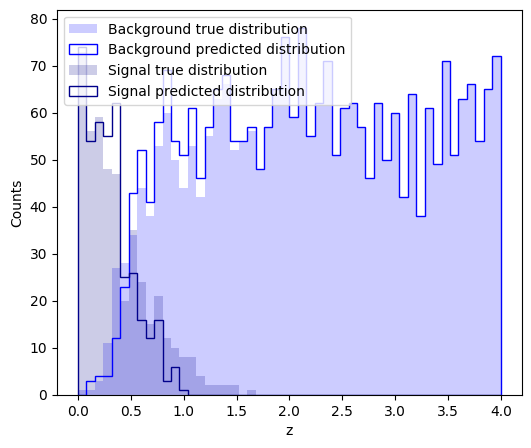

In [9]:
# let's plot the results over the actual datas
labels=['Background','Signal']
colors=['blue','darkblue']
name=['mtot','q','chi1x','chi1y','chi1z','chi2x','chi2y','chi2z','ra','dec','iota','psi','z']
for i in range(13):
    fig,ax = plt.subplots(1,1,figsize=(6,5))
    limits = (min(X[:,i]), max(X[:,i]))
    for index in [0,1]:
        ax.hist(X_test[y_test==index,i],label=labels[index]+' true distribution',range=limits,bins=50,alpha=0.2,color=colors[index])
        ax.hist(X_test[y_pred==index,i],label=labels[index]+' predicted distribution',range=limits,bins=50,histtype='step',color=colors[index])
    ax.set(xlabel=name[i],ylabel='Counts')
    ax.legend()